En este notebook, utilizamos LightGBM, un potente algoritmo de Gradient Boosting desarrollado por Microsoft.
LightGBM es una alternativa a XGBoost que se caracteriza por su alta velocidad y eficiencia.

Entrena más rápido que XGBoost al usar histogramas en lugar de árboles tradicionales y maneja datos desbalanceados de forma eficiente con is_unbalance=True o scale_pos_weight.

Así que nuevamente, traemos estros datos junto a nuestro preprocesador. De nuevo, como en el caso de XGBoost, no escalaramos nuestras variables numericas.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
import os
from lightgbm import LGBMClassifier
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.metrics import confusion_matrix, classification_report, recall_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, StratifiedKFold

In [2]:
os.chdir('/content/drive/MyDrive/data_fraud')

In [66]:
#supongamos que aquí llamamos a nuestros datos de entrenamiento
train_data = pd.read_csv('train.csv')

# Definimos la función para eliminar columnas
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Columnas con alta cardinalidad
        high_cardinality_cols = ['P_emaildomain', 'R_emaildomain', 'id_30', 'id_31', 'id_33', 'DeviceInfo']

        # Columnas con muchos valores nulos (umbral 50%)
        null_cols = ['dist1', 'dist2', 'D2', 'D5', 'D6', 'D7', 'D8', 'D9', 'D11', 'D12', 'D13', 'D14', 'M1', 'M2', 'M3', 'M5', 'M7',
                    'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V138', 'V139', 'V140', 'V141',
                    'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155',
                    'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V169',
                    'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 'V181', 'V182', 'V183',
                    'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V197',
                    'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211',
                    'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225',
                    'V226', 'V227', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239',
                    'V240', 'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V250', 'V251', 'V252', 'V253',
                    'V254', 'V255', 'V256', 'V257', 'V258', 'V259', 'V260', 'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267',
                    'V268', 'V269', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278', 'V322', 'V323', 'V324',
                    'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
                    'V339', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12',
                    'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
                    'id_26', 'id_27', 'id_28', 'id_29', 'id_32', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType']

        # Columnas constantes
        constant_cols = ['V305']

        # Columnas altamente correlacionadas
        corr_cols = {'V62', 'V84', 'C2', 'C11', 'V302', 'C14', 'V45', 'V301', 'V65', 'V280', 'V279', 'V299', 'V308', 'V76', 'C12',
                    'V309', 'V42', 'C6', 'C9', 'V64', 'V73', 'V33', 'V134', 'V137', 'V93', 'V94', 'V28', 'V90', 'V38', 'V125', 'V136',
                    'V119', 'V307', 'V30', 'V79', 'V60', 'V24', 'V113', 'V128', 'V48', 'V34', 'V22', 'V70', 'V91', 'V133', 'V291',
                    'V40', 'V97', 'V285', 'V292', 'C4', 'V36', 'V49', 'V105', 'V87', 'V294', 'V32', 'V284', 'V109', 'V306', 'V289',
                    'V297', 'V106', 'V124', 'V88', 'V102', 'V89', 'V31', 'V316', 'V16', 'V63', 'V13', 'V295', 'V101', 'V83', 'V311',
                    'C10', 'V131', 'V72', 'V43', 'V96', 'C13', 'V20', 'V69', 'V112', 'V21', 'V100', 'V318', 'V54', 'V111', 'V123',
                    'V317', 'V303', 'V57', 'V298', 'V18', 'V287', 'V315', 'C7', 'V59', 'V15', 'V52', 'V58', 'V118', 'V320', 'V110',
                    'V78', 'V85', 'V321', 'V312', 'V92', 'V50', 'TransactionDT', 'V127', 'V122', 'V304', 'V81', 'V71', 'V80', 'V74',
                    'V26', 'V116', 'V293', 'V103', 'V310', 'C8', 'V132', 'V51', 'V114', 'V296', 'V68', 'V126'}

        # Columnas no predictivas
        non_predictive_cols = ['TransactionID']

        # Combinamos todas las columnas a eliminar
        all_cols_to_drop = high_cardinality_cols + null_cols + constant_cols + list(corr_cols) + non_predictive_cols

        # Eliminamos las columnas
        X = X.drop(columns=all_cols_to_drop)

        return X

# Funciones de transformación
def log_transform(x):
    return np.log1p(x)

def inverse_log_transform(x):
    x_reflected = x.max() - x  # Reflejamos valores
    return np.log1p(x_reflected)

def sqrt_transform(x):
    return np.sqrt(abs(x))

# Columnas categóricas y numéricas
categorical_features = ['ProductCD', 'card4', 'card6', 'M4', 'M6']
numeric_mean_log_cols = ['V66']
numeric_median_log_cols = ['TransactionAmt', 'card3', 'C1', 'C3', 'C5', 'D3', 'V17',
                           'V23', 'V27', 'V37', 'V39', 'V44', 'V46', 'V47', 'V55', 'V56',
                           'V67', 'V77', 'V86', 'V95', 'V98', 'V99', 'V104', 'V108', 'V115',
                           'V117', 'V120', 'V121', 'V129', 'V130', 'V135', 'V281', 'V282', 'V283',
                           'V286', 'V288', 'V290', 'V300', 'V313', 'V314', 'V319']
numeric_median_sqrt_cols = ['card5', 'D1', 'D4', 'D10', 'D15']
numeric_median_inv_cols = ['addr2', 'V14', 'V25', 'V41', 'V107']
numeric_mean_cols = ['card1', 'card2', 'addr1', 'V12', 'V35', 'V53', 'V61', 'V75']
numeric_median_cols = ['V19', 'V29', 'V82']

# Creamos los transformadores
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_mean_log_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    #('log', FunctionTransformer(log_transform)),
    #('scaler', StandardScaler())
])

numeric_median_log_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    #('log', FunctionTransformer(log_transform)),
    #('scaler', StandardScaler())
])

numeric_median_sqrt_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    #('sqrt', FunctionTransformer(sqrt_transform)),
    #('scaler', StandardScaler())
])

numeric_median_inv_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    #('inv', FunctionTransformer(inverse_log_transform)),
    #('scaler', StandardScaler())
])

numeric_mean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    #('scaler', StandardScaler())
])

numeric_median_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    #('scaler', StandardScaler())
])

# Unir los transformadores en un preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num_mean_log', numeric_mean_log_transformer, numeric_mean_log_cols),
        ('num_median_log', numeric_median_log_transformer, numeric_median_log_cols),
        ('num_median_sqrt', numeric_median_sqrt_transformer, numeric_median_sqrt_cols),
        ('num_median_inv', numeric_median_inv_transformer, numeric_median_inv_cols),
        ('num_mean', numeric_mean_transformer, numeric_mean_cols),
        ('num_median', numeric_median_transformer, numeric_median_cols),
        ('cat', categorical_transformer, categorical_features)
    ])

# Crear el pipeline completo
pipeline = Pipeline(steps=[('drop_columns', DropColumns()),
                           ('preprocessor', preprocessor)])

# Separar el target y las características
X_train = train_data.drop(columns=['isFraud'])
y_train = train_data['isFraud']

# Ajustar el pipeline y transformar los datos
X_train_prepared = pipeline.fit_transform(X_train)

# Ahora X_train_prepared esta listo para ser usado en los algoritmos de entrenamiento

A continuación, creamos nuestra instancia de modelo con especificaciones similares a las que usamos en nuestro mejor modelo de XGBoost y los entrenamos.

In [59]:
modelo_lgbm = LGBMClassifier(n_estimators=400, learning_rate=0.1, max_depth=15, subsample=0.8, colsample_bytree=0.8, is_unbalance=True, random_state=42)

modelo_lgbm.fit(X_train_prepared, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12398, number of negative: 119999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5129
[LightGBM] [Info] Number of data points in the train set: 132397, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093643 -> initscore=-2.269948
[LightGBM] [Info] Start training from score -2.269948


LGBMClassifier(colsample_bytree=0.8, is_unbalance=True, max_depth=15,
               n_estimators=400, random_state=42, subsample=0.8)

In [5]:
# traemos nuestros datos de validación
val_data = pd.read_csv('val.csv')

X_val = val_data.drop(columns=['isFraud'])
y_val = val_data['isFraud']

# Preprocesamos los datos de validación
x_val_prepared = pipeline.transform(X_val)

In [6]:
y_val_pred = modelo_lgbm.predict(x_val_prepared)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [61]:
# Vamos a ver nuestras metricas
acc_val = accuracy_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
conf_matrix_val = confusion_matrix(y_val, y_val_pred)

print(f"Accuracy en validación: {acc_val}")
print(f"Recall en validación: {recall_val}")
print("Matriz de confusión en validación:")
print(conf_matrix_val)

Accuracy en validación: 0.8974690141164208
Recall en validación: 0.7940962980885555
Matriz de confusión en validación:
[[36326  3674]
 [  851  3282]]


Nuestras métricas en validación son buenas, para ser nuestro primer intento, vamos hacer un segundo intento cambiando is_unbalance=True por  scale_pos_weight=10 para ver si mejor el aprendizaje en lase minoritaria.

In [67]:
modelo_2_lgbm = LGBMClassifier(
    n_estimators=500,  # con más árboles para una mejor generalización
    learning_rate=0.07,  # Reducimos un poco para evitar overfitting
    max_depth=18,  # Un poco más profundo para captar más patrones
    subsample=0.85,  # Evitamos overfitting tomando menos datos por árbol
    colsample_bytree=0.85,  # Más columnas por árbol para más información
    scale_pos_weight=10,  # Ajustamos manualmente el desbalance
    random_state=42
)



In [68]:
modelo_2_lgbm.fit(X_train_prepared, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12398, number of negative: 119999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5127
[LightGBM] [Info] Number of data points in the train set: 132397, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093643 -> initscore=-2.269948
[LightGBM] [Info] Start training from score -2.269948


LGBMClassifier(colsample_bytree=0.85, learning_rate=0.07, max_depth=18,
               n_estimators=500, random_state=42, scale_pos_weight=10,
               subsample=0.85)

In [69]:
# probamos en nuestro conjunto de validación
y_val_pred_2 = modelo_2_lgbm.predict(x_val_prepared)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [70]:
# Evaluamos nuestras métricas

acc_val_2 = accuracy_score(y_val, y_val_pred_2)
recall_val_2 = recall_score(y_val, y_val_pred_2)
conf_matrix_val_2 = confusion_matrix(y_val, y_val_pred_2)

print(f"Accuracy en validación: {acc_val_2}")
print(f"Recall en validación: {recall_val_2}")
print("Matriz de confusión en validación:")
print(conf_matrix_val_2)

Accuracy en validación: 0.9141911947975437
Recall en validación: 0.49310428260343575
Matriz de confusión en validación:
[[38308  1692]
 [ 2095  2038]]


Nuestro Recall subio muy poco. Hagamos un tercer intento en con el scale_pos_weight más alto aún,  veamos como se comporta el accuracy.

In [22]:
modelo_3_lgbm = LGBMClassifier(
    n_estimators=500,  # con más árboles para una mejor generalización
    learning_rate=0.07,  # Reducimos un poco para evitar overfitting
    max_depth=18,  # Un poco más profundo para captar más patrones
    subsample=0.85,  # Evitamos overfitting tomando menos datos por árbol
    colsample_bytree=0.85,  # Más columnas por árbol para más información
    scale_pos_weight=15,  # Ajustamos manualmente el desbalance
    random_state=42
)



In [23]:
modelo_3_lgbm.fit(X_train_prepared, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12398, number of negative: 119999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5112
[LightGBM] [Info] Number of data points in the train set: 132397, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093643 -> initscore=-2.269948
[LightGBM] [Info] Start training from score -2.269948


LGBMClassifier(colsample_bytree=0.85, learning_rate=0.07, max_depth=18,
               n_estimators=500, random_state=42, scale_pos_weight=15,
               subsample=0.85)

In [24]:
y_val_pred_3 = modelo_3_lgbm.predict(x_val_prepared)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [25]:
# Evaluemos los resultados de nuestro tercer modelo

acc_val_3 = accuracy_score(y_val, y_val_pred_3)
recall_val_3 = recall_score(y_val, y_val_pred_3)
conf_matrix_val_3 = confusion_matrix(y_val, y_val_pred_3)

print(f"Accuracy en validación: {acc_val_3}")
print(f"Recall en validación: {recall_val_3}")
print(f"Matriz de confusión en validación:\n{conf_matrix_val_3}")

Accuracy en validación: 0.8524460154532889
Recall en validación: 0.839099927413501
Matriz de confusión en validación:
[[34153  5847]
 [  665  3468]]


LGBM usa log loss por defecto, pero podemos probar AUC-PR, que es mejor para datasets desbalanceados.

In [35]:
modelo_4_lgbm = LGBMClassifier(
    objective="binary",  # Evita optimización por log loss
    metric="auc",  # Evalúa mejor la clasificación en fraudes
    n_estimators=500,
    learning_rate=0.07,
    max_depth=18,
    scale_pos_weight=20,
    random_state=42
)


In [36]:
modelo_4_lgbm.fit(X_train_prepared, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12398, number of negative: 119999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5112
[LightGBM] [Info] Number of data points in the train set: 132397, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093643 -> initscore=-2.269948
[LightGBM] [Info] Start training from score -2.269948


LGBMClassifier(learning_rate=0.07, max_depth=18, metric='auc', n_estimators=500,
               objective='binary', random_state=42, scale_pos_weight=20)

In [37]:
y_pred_4 = modelo_4_lgbm.predict(x_val_prepared)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [38]:
# Evaluemos el desempeño

acc_val_4 = accuracy_score(y_val, y_pred_4)
recall_val_4 = recall_score(y_val, y_pred_4)
conf_matrix_val_4 = confusion_matrix(y_val, y_pred_4)

print(f"Accuracy en validación: {acc_val_4}")
print(f"Recall en validación: {recall_val_4}")
print(f"Matriz de confusión en validación:\n{conf_matrix_val_4}")

Accuracy en validación: 0.8154215666281467
Recall en validación: 0.8744253568836197
Matriz de confusión en validación:
[[32373  7627]
 [  519  3614]]


In [41]:
from scipy.stats import randint

# Definimos el espacio de búsqueda de hiperparámetros
param_dist = {
    'objective': ['binary'],
    'metric': ['auc', 'binary_logloss'],
    'n_estimators': randint(490, 520),
    'learning_rate': (0.07, 0.08),
    'max_depth': (18,19),
    'scale_pos_weight': randint(19,22),
    }

# Creamos una instancia de RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=LGBMClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=50,
    scoring='recall',
    cv=StratifiedKFold(n_splits=5),  # Estrategia de validación cruzada
    n_jobs=-1,  # Usamos todos los núcleos del procesador
    verbose=2  # Mostramos información del progreso
)

# Ajustamos el modelo con los datos de entrenamiento
random_search.fit(X_train_prepared, y_train)

# Obtenemos los mejores hiperparámetros
best_params = random_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Creamos un nuevo modelo con los mejores hiperparámetros
best_model = LGBMClassifier(**best_params, random_state=42)
best_model.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12398, number of negative: 119999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5112
[LightGBM] [Info] Number of data points in the train set: 132397, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093643 -> initscore=-2.269948
[LightGBM] [Info] Start training from score -2.269948
Mejores hiperparámetros: {'learning_rate': 0.07, 'max_depth': 19, 'metric': 'auc', 'n_estimators': 492, 'objective': 'binary', 'scale_pos_weight': 21}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12398, number of negative: 119999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.119327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5112
[LightGBM] [Info] Number of data points in the train set: 132397, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093643 -> initscore=-2.269948
[LightGBM] [Info] Start training from score -2.269948


LGBMClassifier(learning_rate=0.07, max_depth=19, metric='auc', n_estimators=492,
               objective='binary', random_state=42, scale_pos_weight=21)

In [45]:
# Evaluamos el modelo en nuestro conjutno de validación

y_val_pred_5 = best_model.predict(x_val_prepared)

acc_val_5 = accuracy_score(y_val, y_val_pred_5)
recall_val_5 = recall_score(y_val, y_val_pred_5)
conf_matrix_val_5 = confusion_matrix(y_val, y_val_pred_5)

print(f"Accuracy en validación: {acc_val_5}")
print(f"Recall en validación: {recall_val_5}")
print(f"Matriz de confusión en validación:\n{conf_matrix_val_5}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Accuracy en validación: 0.8094396483357125
Recall en validación: 0.8799903218001451
Matriz de confusión en validación:
[[32086  7914]
 [  496  3637]]


Es interesante ver que no logramos mejorar a pesar de una búsqueda hiperparámetros extensa, que hemos quitado por el bien de nuestro código.

Vamos a probar con los umbrales de decisión, viendo que estamos topados en el rendimiento natural de las técnicas de modelado.

In [46]:
y_val_probs = modelo_lgbm.predict_proba(x_val_prepared)[:, 1]

# Ajustamos el umbral de clasificación
nuevo_umbral = 0.3
y_val_adjusted = (y_val_probs > nuevo_umbral).astype(int)

# Evaluamos el nuevo recall
recall_val_adj = recall_score(y_val, y_val_adjusted)
print(f"Nuevo Recall en validación: {recall_val_adj}")

acc_val_adj = accuracy_score(y_val, y_val_adjusted)
print(f"Nuevo Accuracy en validación: {acc_val_adj}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Nuevo Recall en validación: 0.892088071618679
Nuevo Accuracy en validación: 0.7883669816237283


Vayamos con nuestro 2do modelo:

In [47]:
y_val_probs_2 = modelo_2_lgbm.predict_proba(x_val_prepared)[:, 1]

# Ajustamos el umbral de clasificación
nuevo_umbral = 0.35
y_val_adjusted_2 = (y_val_probs > nuevo_umbral).astype(int)

# Evaluamos el nuevo recall
recall_val_adj_2 = recall_score(y_val, y_val_adjusted_2)
print(f"Nuevo Recall en validación: {recall_val_adj_2}")

acc_val_adj_2 = accuracy_score(y_val, y_val_adjusted_2)
print(f"Nuevo Accuracy en validación: {acc_val_adj_2}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Nuevo Recall en validación: 0.8698282119525769
Nuevo Accuracy en validación: 0.8282464369066231


El segundo modelo, junto al ajuste de umbral es ya bastante bueno, vamos a probar nuestro tercer modelo con está técnica de ajuste:

In [52]:
y_val_probs_3 = modelo_3_lgbm.predict_proba(x_val_prepared)[:, 1]

# Ajustamos el umbral de clasificación
nuevo_umbral = 0.35
y_val_adjusted_3 = (y_val_probs > nuevo_umbral).astype(int)

# Evaluamos el nuevo recall
recall_val_adj_3 = recall_score(y_val, y_val_adjusted_3)
print(f"Nuevo Recall en validación: {recall_val_adj_3}")

acc_val_adj_3 = accuracy_score(y_val, y_val_adjusted_3)
print(f"Nuevo Accuracy en validación: {acc_val_adj_3}")

conf_matrix_adj_3 = confusion_matrix(y_val, y_val_adjusted_3)
print("Matriz de confusión en validación:")
print(conf_matrix_adj_3)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Nuevo Recall en validación: 0.8698282119525769
Nuevo Accuracy en validación: 0.8282464369066231
Matriz de confusión en validación:
[[32958  7042]
 [  538  3595]]


In [54]:
y_val_probs_4 = modelo_4_lgbm.predict_proba(x_val_prepared)[:, 1]

# Ajustamos el umbral de clasificación
nuevo_umbral = 0.29
y_val_adjusted_4 = (y_val_probs > nuevo_umbral).astype(int)

# Evaluamos el nuevo recall
recall_val_adj_4 = recall_score(y_val, y_val_adjusted_4)
print(f"Nuevo Recall en validación: {recall_val_adj_4}")

acc_val_adj_4 = accuracy_score(y_val, y_val_adjusted_4)
print(f"Nuevo Accuracy en validación: {acc_val_adj_4}")

conf_matrix_adj_4 = confusion_matrix(y_val, y_val_adjusted_4)
print("Matriz de confusión en validación:")
print(conf_matrix_adj_4)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Nuevo Recall en validación: 0.8988628115170578
Nuevo Accuracy en validación: 0.7790768812453266
Matriz de confusión en validación:
[[30668  9332]
 [  418  3715]]


Parece ser que todos nuestros intentos por mejorar el accuracy resultan en proporcional descenso de nuestro Recall y viceversa, no perdamos de vista nuestro objetivo, que es la maximización del Recall, para así detectar la mayor cantidad de fraudes posibles, continuando en ese objetivo, vamos a elegir nuestro modelo 4, sin ajuste de umbral.  Se unira a nuestro pipeline de preprocesamiento para crear nuestro pipeline final.

In [55]:
# Creamos el pipeline final
pipeline_final_lgbm = Pipeline([
    ('preprocesamiento', pipeline),
    ('modelo', modelo_4_lgbm)
])


In [57]:
# Vemos graficamente como funciona nuestro pipeline

from sklearn import set_config
set_config(display='diagram')
pipeline_final_lgbm


Pipeline(steps=[('preprocesamiento',
                 Pipeline(steps=[('drop_columns', DropColumns()),
                                 ('preprocessor',
                                  ColumnTransformer(transformers=[('num_mean_log',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer())]),
                                                                   ['V66']),
                                                                  ('num_median_log',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median'))]),
                                                                   ['TransactionAmt',
                                                                    'card3',
                                                                    'C1', 'C3',
                                                                    'C5', 'D3',
                                                                    'V17',
                                                                    'V23',
                                                                    'V27',
                                                                    'V3...
                                                                                    SimpleImputer(strategy='median'))]),
                                                                   ['V19',
                                                                    'V29',
                                                                    'V82']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['ProductCD',
                                                                    'card4',
                                                                    'card6',
                                                                    'M4',
                                                                    'M6'])]))])),
                ('modelo',
                 LGBMClassifier(learning_rate=0.07, max_depth=18, metric='auc',
                                n_estimators=500, objective='binary',
                                random_state=42, scale_pos_weight=20))])

In [71]:
# Traemos nuestros datos de prueba

data_test = pd.read_csv('test.csv')

X_test = data_test.drop(columns=['isFraud'])
y_test = data_test['isFraud']

In [72]:
y_test_pred = pipeline_final_lgbm.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


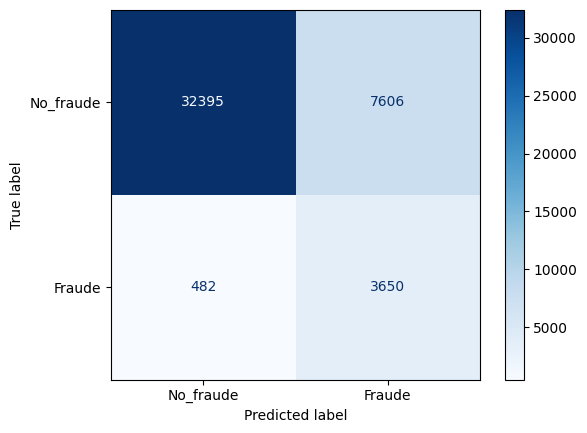

Accuracy en el conjunto de prueba: 0.8167357759499694
Recall en el conjunto de prueba: 0.883349467570184


In [73]:
# Finalmente evaluemos nuestros resultados en datos no vistos

acc_test = accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)

# tambien obtenemos nuestra matriz de confussion, pero de una forma más llamtiva
matriz_confusion_test = confusion_matrix(y_test, y_test_pred)

# Visualización de la matriz de confusión
cm_display = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion_test,
                                    display_labels=['No_fraude', 'Fraude'])
cm_display.plot(cmap=plt.cm.Blues)
plt.show()


print(f"Accuracy en el conjunto de prueba: {acc_test}")
print(f"Recall en el conjunto de prueba: {recall_test}")


Este modelo tiene la ventaja de ser rápido, no tenemos que cambiarle el umbral de decisión, ésto es lo óptimo, y podría servir como un primer modelo en nuestra detección de frades, ya que, justamente las transacciones se deben autorizar o descafrtar a la brevedad, para no interferir en los procesos de pago de nuestros clientes. Un modelo agil como éste puede servir como esa primer capa, una vez que una transacción se clasifique como fraudulenta, se puede mandar a otro modelo más robusto que confirme o niegue lo fraudulento de la transacción y autorize la operación si es el caso.  